### 数据展示

In [1]:
from sklearn.model_selection import train_test_split
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model
import xgboost as xgb
from ultis import *

道路通行时间：

In [2]:
df = pd.read_csv('new_gy_contest_traveltime_training_data_second.txt', delimiter=';', dtype={'link_ID': object})
df.head()

,link_ID,date,time_interval,travel_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4


道路长宽情况：

In [3]:
link_df = pd.read_csv('gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
link_df.head()

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


道路连接情况：

In [4]:
link_tops = pd.read_csv('gy_contest_link_top.txt', delimiter=',', dtype={'link_ID': object})
link_tops.head()

,link_ID,in_links,out_links
0,4377906289869500514,1,1
1,4377906284594800514,1,1
2,4377906289425800514,1,1
3,4377906284525800514,1,1
4,4377906284422600514,2,1


### 数据集筛选与标签转换

- 数据集中有些数据可能由于异常情况导致不适合建模（堵车，维修等）

In [5]:
df = pd.read_csv('new_gy_contest_traveltime_training_data_second.txt', delimiter=';', dtype={'link_ID': object})
df.head()

,link_ID,date,time_interval,travel_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4


截取开始时间

In [6]:
df['time_interval_begin'] = pd.to_datetime(df['time_interval'].map(lambda x: x[1:20]))
df.head()

,link_ID,date,time_interval,travel_time,time_interval_begin
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0,2017-05-06 11:04:00
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0,2017-05-06 10:42:00
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2,2017-05-06 11:56:00
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2,2017-05-06 17:46:00
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4,2017-05-06 10:52:00


标签转换

![title](./img/1.png)

In [7]:
df = df.drop(['time_interval'], axis=1)
df['travel_time'] = np.log1p(df['travel_time'])

筛选方法

In [8]:
#剔除掉一些离群点
def quantile_clip(group):     
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
    return group

In [9]:
#对每条道路，每天执行
df['travel_time'] = df.groupby(['link_ID', 'date'])['travel_time'].transform(quantile_clip)
df.head(5)

,link_ID,date,travel_time,time_interval_begin
0,4377906283422600514,2017-05-06,1.386294,2017-05-06 11:04:00
1,3377906289434510514,2017-05-06,0.693147,2017-05-06 10:42:00
2,3377906285934510514,2017-05-06,3.589059,2017-05-06 11:56:00
3,3377906285934510514,2017-05-06,3.303217,2017-05-06 17:46:00
4,3377906287934510514,2017-05-06,2.251292,2017-05-06 10:52:00


In [10]:
#根据需求来选择样本数据
df = df.loc[(df['time_interval_begin'].dt.hour.isin([6, 7, 8, 13, 14, 15, 16, 17, 18]))]

保存处理结果

In [11]:
df.to_csv('data/raw_data.txt', header=True, index=None, sep=';', mode='w')

### 缺失值预处理

In [12]:
df = pd.read_csv('data/raw_data.txt', delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})
df.head()

,link_ID,date,travel_time,time_interval_begin
0,3377906285934510514,2017-05-06,3.303217,2017-05-06 17:46:00
1,3377906287934510514,2017-05-06,1.887070,2017-05-06 14:36:00
2,3377906287674510514,2017-05-06,1.931521,2017-05-06 06:30:00
3,3377906287886510514,2017-05-06,3.616309,2017-05-06 07:32:00
4,4377906283759500514,2017-05-06,2.140066,2017-05-06 13:24:00


In [13]:
link_df = pd.read_csv('gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
link_df.head()

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


构建时间序列数据，原始数据表中没有列出的数据均需要填充

In [14]:
date_range = pd.date_range("2017-03-01 00:00:00", "2017-07-31 23:58:00", freq='2min')
date_range[:5]

DatetimeIndex(['2017-03-01 00:00:00', '2017-03-01 00:02:00',
               '2017-03-01 00:04:00', '2017-03-01 00:06:00',
               '2017-03-01 00:08:00'],
              dtype='datetime64[ns]', freq='2T')

In [15]:
new_index = pd.MultiIndex.from_product([link_df['link_ID'].unique(), date_range],
                                       names=['link_ID', 'time_interval_begin'])
new_df = pd.DataFrame(index=new_index).reset_index()
new_df.head()

,link_ID,time_interval_begin
0,4377906289869500514,2017-03-01 00:00:00
1,4377906289869500514,2017-03-01 00:02:00
2,4377906289869500514,2017-03-01 00:04:00
3,4377906289869500514,2017-03-01 00:06:00
4,4377906289869500514,2017-03-01 00:08:00


In [16]:
#合并，出现大量缺失值
df2 = pd.merge(new_df, df, on=['link_ID', 'time_interval_begin'], how='left')

In [17]:
df2.head()

,link_ID,time_interval_begin,date,travel_time
0,4377906289869500514,2017-03-01 00:00:00,NaN,NaN
1,4377906289869500514,2017-03-01 00:02:00,NaN,NaN
2,4377906289869500514,2017-03-01 00:04:00,NaN,NaN
3,4377906289869500514,2017-03-01 00:06:00,NaN,NaN
4,4377906289869500514,2017-03-01 00:08:00,NaN,NaN


筛选所需时间段数据

In [18]:
df2 = df2.loc[(df2['time_interval_begin'].dt.hour.isin([6, 7, 8, 13, 14, 15, 16, 17, 18]))]
df2 = df2.loc[~((df2['time_interval_begin'].dt.year == 2017) & (df2['time_interval_begin'].dt.month == 7) & (
    df2['time_interval_begin'].dt.hour.isin([8, 15, 18])))]
df2 = df2.loc[~((df2['time_interval_begin'].dt.year == 2017) & (df2['time_interval_begin'].dt.month == 3) & (
    df2['time_interval_begin'].dt.day == 31))]

df2['date'] = df2['time_interval_begin'].dt.strftime('%Y-%m-%d')

In [19]:
df2.head()

,link_ID,time_interval_begin,date,travel_time
180,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752
181,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752
182,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752
183,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752
184,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752


保存中间结果

In [20]:
df2.to_csv('data/pre_training.txt', header=True, index=None, sep=';', mode='w')

### 补全时间序列

In [21]:
df = pd.read_csv('data/pre_training.txt', delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})
df['travel_time2'] = df['travel_time']
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752,2.174752
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752,2.174752
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752,2.174752
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752,2.174752
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752,2.174752


多个月统计-季节性变化

In [22]:
def date_trend(group):
    tmp = group.groupby('date_hour').mean().reset_index()

    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]

    y = tmp['travel_time'].values
    nans, x = nan_helper(y)
    if group.link_ID.values[0] in ['3377906282328510514', '3377906283328510514', '4377906280784800514',
                                   '9377906281555510514']:
        tmp['date_trend'] = group['travel_time'].median()
    else:
        regr = linear_model.LinearRegression()
        regr.fit(x(~nans).reshape(-1, 1), y[~nans].reshape(-1, 1))
        tmp['date_trend'] = regr.predict(tmp.index.values.reshape(-1, 1)).ravel()
    group = pd.merge(group, tmp[['date_trend', 'date_hour']], on='date_hour', how='left')
    return group

In [23]:
df['date_hour'] = df.time_interval_begin.map(lambda x: x.strftime('%Y-%m-%d-%H'))
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_hour
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752,2.174752,2017-03-01-06
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752,2.174752,2017-03-01-06
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752,2.174752,2017-03-01-06
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752,2.174752,2017-03-01-06
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752,2.174752,2017-03-01-06


道路每小时通行时间的回归结果

![title](./img/2.png)

In [24]:
df = df.groupby('link_ID').apply(date_trend)
df.head()

link_ID time_interval_begin        date  \
link_ID                                                                      
3377906280028510514 0  3377906280028510514 2017-03-01 06:00:00  2017-03-01   
                    1  3377906280028510514 2017-03-01 06:02:00  2017-03-01   
                    2  3377906280028510514 2017-03-01 06:04:00  2017-03-01   
                    3  3377906280028510514 2017-03-01 06:06:00  2017-03-01   
                    4  3377906280028510514 2017-03-01 06:08:00  2017-03-01   

                       travel_time  travel_time2      date_hour  date_trend  
link_ID                                                                      
3377906280028510514 0          NaN           NaN  2017-03-01-06    1.960745  
                    1          NaN           NaN  2017-03-01-06    1.960745  
                    2          NaN           NaN  2017-03-01-06    1.960745  
                    3          NaN           NaN  2017-03-01-06    1.960745  
                    4          NaN           NaN  2017-03-01-06    1.960745

蓝线回归得到的值存在df['date_trend']里，此时travel_time就更新为df['travel_time'] = df['travel_time'] - df['date_trend']，表示date_trend作为大的趋势已经被线性回归决定了，剩下的就是研究这个残差了，之后训练和预测都是基于残差，最后用预测出来的残差加上相应的date_trend即可得到需要的预测值

In [25]:
df = df.drop(['date_hour', 'link_ID'], axis=1)
df = df.reset_index()
df = df.drop('level_1', axis=1)
df['travel_time'] = df['travel_time'] - df['date_trend']
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745


日变化量（分钟）

In [26]:
def minute_trend(group):
    tmp = group.groupby('hour_minute').mean().reset_index()
    #s的值越小，对数据拟合越好，但是会过拟合的危险；
    spl = UnivariateSpline(tmp.index, tmp['travel_time'].values, s=0.5)
    tmp['minute_trend'] = spl(tmp.index)
    group = pd.merge(group, tmp[['minute_trend', 'hour_minute']], on='hour_minute', how='left')

    return group

In [27]:
df['hour_minute'] = df.time_interval_begin.map(lambda x: x.strftime('%H-%M'))
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,hour_minute
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,06-00
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,06-02
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,06-04
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,06-06
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,06-08


In [28]:
df = df.groupby('link_ID').apply(minute_trend)

In [29]:
df.head()

link_ID time_interval_begin        date  \
link_ID                                                                      
3377906280028510514 0  3377906280028510514 2017-03-01 06:00:00  2017-03-01   
                    1  3377906280028510514 2017-03-01 06:02:00  2017-03-01   
                    2  3377906280028510514 2017-03-01 06:04:00  2017-03-01   
                    3  3377906280028510514 2017-03-01 06:06:00  2017-03-01   
                    4  3377906280028510514 2017-03-01 06:08:00  2017-03-01   

                       travel_time  travel_time2  date_trend hour_minute  \
link_ID                                                                    
3377906280028510514 0          NaN           NaN    1.960745       06-00   
                    1          NaN           NaN    1.960745       06-02   
                    2          NaN           NaN    1.960745       06-04   
                    3          NaN           NaN    1.960745       06-06   
                    4          NaN           NaN    1.960745       06-08   

                       minute_trend  
link_ID                              
3377906280028510514 0     -0.252121  
                    1     -0.246743  
                    2     -0.241428  
                    3     -0.236176  
                    4     -0.230986

与季节残差一样，回归得到的值存在df['minute_trend']里，因此现在的travel_time再次更新为df['travel_time'] = df['travel_time'] - df['minute_trend']

In [30]:
df = df.drop(['hour_minute', 'link_ID'], axis=1)
df = df.reset_index()
df = df.drop('level_1', axis=1)
df['travel_time'] = df['travel_time'] - df['minute_trend']

In [31]:
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986


基本上大概的走势已经被date_trend和hour_trend决定了，剩下就是建模得到这个travel_time如何围绕这两个trends上下变化的

选择训练特征：

In [32]:
link_infos = pd.read_csv('gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
link_tops = pd.read_csv('gy_contest_link_top.txt', delimiter=',', dtype={'link_ID': object})

In [33]:
link_infos = pd.merge(link_infos, link_tops, on=['link_ID'], how='left') #合并道路信息
link_infos['links_num'] = link_infos["in_links"]+link_infos["out_links"] #总和
link_infos['area'] = link_infos['length'] * link_infos['width'] #面积
df = pd.merge(df, link_infos[['link_ID', 'length', 'width', 'links_num', 'area']], on=['link_ID'], how='left') #组合特征
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144


时间相关特征

In [34]:
df.loc[df['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 1

df.loc[~df['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 0

df['minute'] = df['time_interval_begin'].dt.minute
df['hour'] = df['time_interval_begin'].dt.hour
df['day'] = df['time_interval_begin'].dt.day
df['week_day'] = df['time_interval_begin'].map(lambda x: x.weekday() + 1)
df['month'] = df['time_interval_begin'].dt.month
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area,vacation,minute,hour,day,week_day,month
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144,0.0,0,6,1,3,3
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144,0.0,2,6,1,3,3
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144,0.0,4,6,1,3,3
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144,0.0,6,6,1,3,3
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144,0.0,8,6,1,3,3


In [35]:
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()
    return group

In [36]:
df = df.groupby('link_ID').apply(mean_time)
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area,vacation,minute,hour,day,week_day,month,link_ID_en
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144,0.0,0,6,1,3,3,0.000138
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144,0.0,2,6,1,3,3,0.000138
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144,0.0,4,6,1,3,3,0.000138
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144,0.0,6,6,1,3,3,0.000138
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144,0.0,8,6,1,3,3,0.000138


In [37]:
#同行时间长的编号大
sorted_link = np.sort(df['link_ID_en'].unique())
df['link_ID_en'] = df['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))

In [38]:
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area,vacation,minute,hour,day,week_day,month,link_ID_en
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144,0.0,0,6,1,3,3,75
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144,0.0,2,6,1,3,3,75
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144,0.0,4,6,1,3,3,75
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144,0.0,6,6,1,3,3,75
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144,0.0,8,6,1,3,3,75


标准化

In [39]:
def std(group):
    group['travel_time_std'] = np.std(group['travel_time'])
    return group

In [40]:
df = df.groupby('link_ID').apply(std)
df['travel_time'] = df['travel_time'] / df['travel_time_std']
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area,vacation,minute,hour,day,week_day,month,link_ID_en,travel_time_std
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144,0.0,0,6,1,3,3,75,0.223232
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144,0.0,2,6,1,3,3,75,0.223232
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144,0.0,4,6,1,3,3,75,0.223232
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144,0.0,6,6,1,3,3,75,0.223232
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144,0.0,8,6,1,3,3,75,0.223232


缺失时间预测

In [41]:
params = {
        'learning_rate': 0.2,
        'n_estimators': 30,
        'subsample': 0.8,
        'colsample_bytree': 0.6,
        'max_depth': 10,
        'min_child_weight': 1,
        'reg_alpha': 0,
        'gamma': 0
    }

In [42]:
df = pd.get_dummies(df, columns=['links_num', 'width', 'minute', 'hour', 'week_day', 'day', 'month'])
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,area,vacation,...,day_27,day_28,day_29,day_30,day_31,month_3,month_4,month_5,month_6,month_7
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0


训练的数据train_df 为travel_time非空的数据，而测试集test_df为travel_time空的数据

In [43]:
feature = df.columns.values.tolist()
train_feature = [x for x in feature if
                 x not in ['link_ID', 'time_interval_begin', 'travel_time', 'date', 'travel_time2', 'minute_trend',
                           'travel_time_std', 'date_trend']]

train_df = df.loc[~df['travel_time'].isnull()]
test_df = df.loc[df['travel_time'].isnull()].copy()

print (train_feature)

['length', 'area', 'vacation', 'link_ID_en', 'links_num_2', 'links_num_3', 'links_num_4', 'links_num_5', 'width_3', 'width_6', 'width_9', 'width_12', 'width_15', 'minute_0', 'minute_2', 'minute_4', 'minute_6', 'minute_8', 'minute_10', 'minute_12', 'minute_14', 'minute_16', 'minute_18', 'minute_20', 'minute_22', 'minute_24', 'minute_26', 'minute_28', 'minute_30', 'minute_32', 'minute_34', 'minute_36', 'minute_38', 'minute_40', 'minute_42', 'minute_44', 'minute_46', 'minute_48', 'minute_50', 'minute_52', 'minute_54', 'minute_56', 'minute_58', 'hour_6', 'hour_7', 'hour_8', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'week_day_1', 'week_day_2', 'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6', 'week_day_7', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27'

In [44]:
train_df.shape

(3165426, 103)

训练数据切分

In [45]:
X = train_df[train_feature].values
y = train_df['travel_time'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

eval_set = [(X_test, y_test)]

训练回归模型来预测缺失值

In [46]:
regressor = xgb.XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                             booster='gbtree', objective='reg:linear', n_jobs=-1, subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'], random_state=0,
                             max_depth=params['max_depth'], gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])
regressor.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=eval_set)
print (test_df[train_feature].head())
print (test_df[train_feature].info())
test_df['prediction'] = regressor.predict(test_df[train_feature].values)

[0]	validation_0-rmse:1.07202
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.04002
[2]	validation_0-rmse:1.01715
[3]	validation_0-rmse:1.00236
[4]	validation_0-rmse:0.991677
[5]	validation_0-rmse:0.984312
[6]	validation_0-rmse:0.97973
[7]	validation_0-rmse:0.976123
[8]	validation_0-rmse:0.972988
[9]	validation_0-rmse:0.970959
[10]	validation_0-rmse:0.968661
[11]	validation_0-rmse:0.967046
[12]	validation_0-rmse:0.966183
[13]	validation_0-rmse:0.965061
[14]	validation_0-rmse:0.964424
[15]	validation_0-rmse:0.96363
[16]	validation_0-rmse:0.962258
[17]	validation_0-rmse:0.961248
[18]	validation_0-rmse:0.960693
[19]	validation_0-rmse:0.960122
[20]	validation_0-rmse:0.959247
[21]	validation_0-rmse:0.958742
[22]	validation_0-rmse:0.958149
[23]	validation_0-rmse:0.957828
[24]	validation_0-rmse:0.957451
[25]	validation_0-rmse:0.956981
[26]	validation_0-rmse:0.956609
[27]	validation_0-rmse:0.955917
[28]	validation_0-rmse:0.955366
[29]	validation_0-rmse:

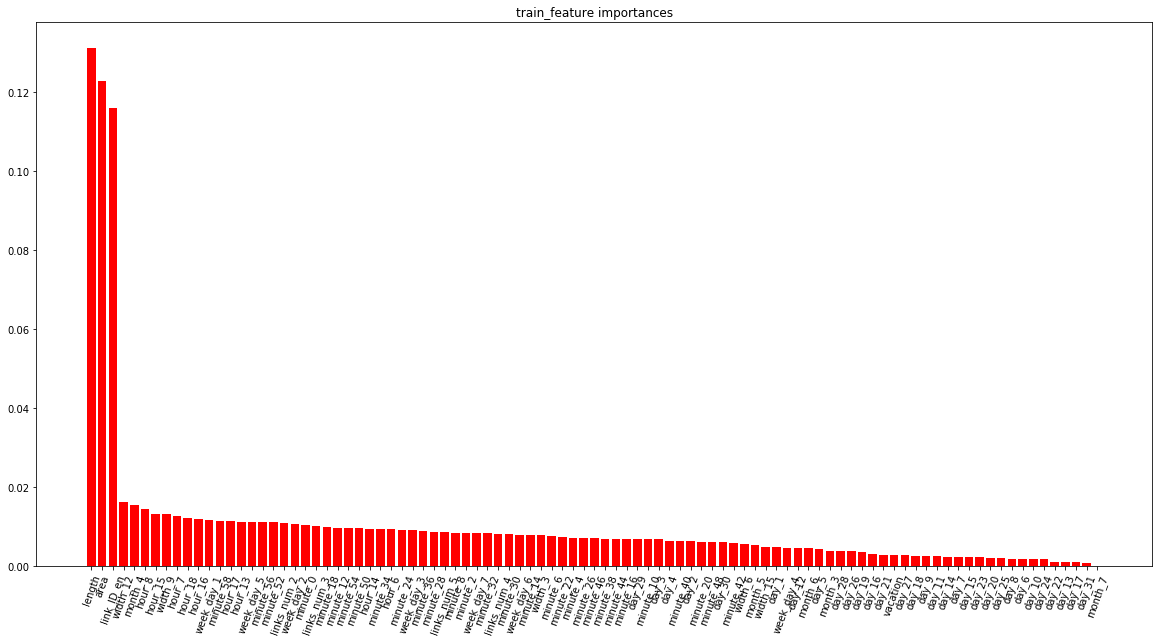

In [47]:
df = pd.merge(df, test_df[['link_ID', 'time_interval_begin', 'prediction']], on=['link_ID', 'time_interval_begin'],
                  how='left')
feature_vis(regressor,train_feature)

还原预测结果

In [48]:
df['imputation1'] = df['travel_time'].isnull()
df['travel_time'] = df['travel_time'].fillna(value=df['prediction'])
df['travel_time'] = (df['travel_time'] * np.array(df['travel_time_std']) + np.array(df['minute_trend'])
                     + np.array(df['date_trend']))

In [49]:
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,area,vacation,...,day_29,day_30,day_31,month_3,month_4,month_5,month_6,month_7,prediction,imputation1
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,1.662360,NaN,1.960745,-0.252121,48,144,0.0,...,0,0,0,1,0,0,0,0,-0.207243,True
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,1.681661,NaN,1.960745,-0.246743,48,144,0.0,...,0,0,0,1,0,0,0,0,-0.144875,True
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,1.676155,NaN,1.960745,-0.241428,48,144,0.0,...,0,0,0,1,0,0,0,0,-0.193346,True
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,1.683786,NaN,1.960745,-0.236176,48,144,0.0,...,0,0,0,1,0,0,0,0,-0.182691,True
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,1.683193,NaN,1.960745,-0.230986,48,144,0.0,...,0,0,0,1,0,0,0,0,-0.208599,True


保存时间序列数据

In [50]:
print (df[['travel_time', 'prediction', 'travel_time2']].describe())
df[['link_ID', 'date', 'time_interval_begin', 'travel_time', 'imputation1']].to_csv('data/com_training.txt', header=True,
                                                                                    index=None,
                                                                                    sep=';', mode='w')

        travel_time    prediction  travel_time2
count  5.049000e+06  1.883574e+06  3.165426e+06
mean   2.392873e+00  4.827908e-02  2.416565e+00
std    9.189660e-01  1.873042e-01  9.521757e-01
min    3.364722e-01 -2.163789e+00  3.364722e-01
25%    1.667707e+00 -5.919063e-02  1.648659e+00
50%    2.379546e+00  5.071995e-02  2.388763e+00
75%    3.063391e+00  1.572115e-01  3.113515e+00
max    5.913699e+00  2.222478e+00  5.913699e+00


### 构建特征

In [2]:
df = pd.read_csv('data/com_training.txt', delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})

In [3]:
df1 = df.copy()

In [4]:
df1.head()

,link_ID,date,time_interval_begin,travel_time,imputation1
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.662360,True
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.681661,True
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.676155,True
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.683786,True
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.683193,True


平移5格

In [5]:
df1['time_interval_begin'] = df1['time_interval_begin'] + pd.DateOffset(minutes=5 * 2)

In [6]:
df1.head()

,link_ID,date,time_interval_begin,travel_time,imputation1
0,3377906280028510514,2017-03-01,2017-03-01 06:10:00,1.662360,True
1,3377906280028510514,2017-03-01,2017-03-01 06:12:00,1.681661,True
2,3377906280028510514,2017-03-01,2017-03-01 06:14:00,1.676155,True
3,3377906280028510514,2017-03-01,2017-03-01 06:16:00,1.683786,True
4,3377906280028510514,2017-03-01,2017-03-01 06:18:00,1.683193,True


In [7]:
df1 = df1.rename(columns={'travel_time': 'lagging' + str(5)})

In [8]:
df1.head()

,link_ID,date,time_interval_begin,lagging5,imputation1
0,3377906280028510514,2017-03-01,2017-03-01 06:10:00,1.662360,True
1,3377906280028510514,2017-03-01,2017-03-01 06:12:00,1.681661,True
2,3377906280028510514,2017-03-01,2017-03-01 06:14:00,1.676155,True
3,3377906280028510514,2017-03-01,2017-03-01 06:16:00,1.683786,True
4,3377906280028510514,2017-03-01,2017-03-01 06:18:00,1.683193,True


合并数据集

In [9]:
df2 = pd.merge(df, df1[['link_ID', 'time_interval_begin', 'lagging' + str(5)]], on=['link_ID', 'time_interval_begin'],how='left')

In [10]:
df2.head(10)

,link_ID,date,time_interval_begin,travel_time,imputation1,lagging5
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.662360,True,NaN
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.681661,True,NaN
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.676155,True,NaN
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.683786,True,NaN
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.683193,True,NaN
5,3377906280028510514,2017-03-01,2017-03-01 06:10:00,1.629241,False,1.662360
6,3377906280028510514,2017-03-01,2017-03-01 06:12:00,1.629241,False,1.681661
7,3377906280028510514,2017-03-01,2017-03-01 06:14:00,1.629241,False,1.676155
8,3377906280028510514,2017-03-01,2017-03-01 06:16:00,1.701797,True,1.683786
9,3377906280028510514,2017-03-01,2017-03-01 06:18:00,1.696063,True,1.683193


In [11]:
def create_lagging(df, df_original, i):
    df1 = df_original.copy()
    df1['time_interval_begin'] = df1['time_interval_begin'] + pd.DateOffset(minutes=i * 2)
    df1 = df1.rename(columns={'travel_time': 'lagging' + str(i)})
    df2 = pd.merge(df, df1[['link_ID', 'time_interval_begin', 'lagging' + str(i)]],
                   on=['link_ID', 'time_interval_begin'],
                   how='left')
    return df2

In [12]:
df1 = create_lagging(df, df, 1)

构建时间序列特征

In [13]:
lagging = 5
for i in range(2, lagging + 1):
    df1 = create_lagging(df1, df, i)

In [14]:
df1.head(10)

,link_ID,date,time_interval_begin,travel_time,imputation1,lagging1,lagging2,lagging3,lagging4,lagging5
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.662360,True,NaN,NaN,NaN,NaN,NaN
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.681661,True,1.662360,NaN,NaN,NaN,NaN
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.676155,True,1.681661,1.662360,NaN,NaN,NaN
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.683786,True,1.676155,1.681661,1.662360,NaN,NaN
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.683193,True,1.683786,1.676155,1.681661,1.662360,NaN
5,3377906280028510514,2017-03-01,2017-03-01 06:10:00,1.629241,False,1.683193,1.683786,1.676155,1.681661,1.662360
6,3377906280028510514,2017-03-01,2017-03-01 06:12:00,1.629241,False,1.629241,1.683193,1.683786,1.676155,1.681661
7,3377906280028510514,2017-03-01,2017-03-01 06:14:00,1.629241,False,1.629241,1.629241,1.683193,1.683786,1.676155
8,3377906280028510514,2017-03-01,2017-03-01 06:16:00,1.701797,True,1.629241,1.629241,1.629241,1.683193,1.683786
9,3377906280028510514,2017-03-01,2017-03-01 06:18:00,1.696063,True,1.701797,1.629241,1.629241,1.629241,1.683193


In [15]:
link_infos = pd.read_csv('gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
link_tops = pd.read_csv('gy_contest_link_top.txt', delimiter=',', dtype={'link_ID': object})

In [16]:
link_tops = link_tops.fillna(0)
link_infos = pd.merge(link_infos, link_tops, on=['link_ID'], how='left')
link_infos['links_num'] = link_infos["in_links"]+link_infos["out_links"]

In [17]:
link_infos['area'] = link_infos['length'] * link_infos['width']
df2 = pd.merge(df1, link_infos[['link_ID', 'length', 'width', 'links_num', 'area']], on=['link_ID'], how='left')

In [18]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputation1,lagging1,lagging2,lagging3,lagging4,lagging5,length,width,links_num,area
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.662360,True,NaN,NaN,NaN,NaN,NaN,48,3,2,144
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.681661,True,1.662360,NaN,NaN,NaN,NaN,48,3,2,144
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.676155,True,1.681661,1.662360,NaN,NaN,NaN,48,3,2,144
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.683786,True,1.676155,1.681661,1.662360,NaN,NaN,48,3,2,144
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.683193,True,1.683786,1.676155,1.681661,1.66236,NaN,48,3,2,144


In [19]:
# 假期特征
df2.loc[df2['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 1
df2.loc[~df2['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 0

In [20]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputation1,lagging1,lagging2,lagging3,lagging4,lagging5,length,width,links_num,area,vacation
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.662360,True,NaN,NaN,NaN,NaN,NaN,48,3,2,144,0.0
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.681661,True,1.662360,NaN,NaN,NaN,NaN,48,3,2,144,0.0
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.676155,True,1.681661,1.662360,NaN,NaN,NaN,48,3,2,144,0.0
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.683786,True,1.676155,1.681661,1.662360,NaN,NaN,48,3,2,144,0.0
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.683193,True,1.683786,1.676155,1.681661,1.66236,NaN,48,3,2,144,0.0


In [21]:
# 起始分钟特征
df2.loc[df2['time_interval_begin'].dt.hour.isin([6, 7, 8]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 6) * 60

df2.loc[df2['time_interval_begin'].dt.hour.isin([13, 14, 15]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 13) * 60

df2.loc[df2['time_interval_begin'].dt.hour.isin([16, 17, 18]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 16) * 60

In [22]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputation1,lagging1,lagging2,lagging3,lagging4,lagging5,length,width,links_num,area,vacation,minute_series
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.662360,True,NaN,NaN,NaN,NaN,NaN,48,3,2,144,0.0,0.0
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.681661,True,1.662360,NaN,NaN,NaN,NaN,48,3,2,144,0.0,2.0
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.676155,True,1.681661,1.662360,NaN,NaN,NaN,48,3,2,144,0.0,4.0
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.683786,True,1.676155,1.681661,1.662360,NaN,NaN,48,3,2,144,0.0,6.0
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.683193,True,1.683786,1.676155,1.681661,1.66236,NaN,48,3,2,144,0.0,8.0


In [23]:
# 星期特征
df2['day_of_week'] = df2['time_interval_begin'].map(lambda x: x.weekday() + 1)
df2.loc[df2['day_of_week'].isin([1, 2, 3]), 'day_of_week_en'] = 1
df2.loc[df2['day_of_week'].isin([4, 5]), 'day_of_week_en'] = 2
df2.loc[df2['day_of_week'].isin([6, 7]), 'day_of_week_en'] = 3

In [24]:
# 时间段特征
df2.loc[df['time_interval_begin'].dt.hour.isin([6, 7, 8]), 'hour_en'] = 1
df2.loc[df['time_interval_begin'].dt.hour.isin([13, 14, 15]), 'hour_en'] = 2
df2.loc[df['time_interval_begin'].dt.hour.isin([16, 17, 18]), 'hour_en'] = 3

In [25]:
# 星期，时间段合并特征
df2['week_hour'] = df2["day_of_week_en"].astype('str') + "," + df2["hour_en"].astype('str')

In [26]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputation1,lagging1,lagging2,lagging3,lagging4,lagging5,length,width,links_num,area,vacation,minute_series,day_of_week,day_of_week_en,hour_en,week_hour
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.662360,True,NaN,NaN,NaN,NaN,NaN,48,3,2,144,0.0,0.0,3,1.0,1.0,"1.0,1.0"
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.681661,True,1.662360,NaN,NaN,NaN,NaN,48,3,2,144,0.0,2.0,3,1.0,1.0,"1.0,1.0"
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.676155,True,1.681661,1.662360,NaN,NaN,NaN,48,3,2,144,0.0,4.0,3,1.0,1.0,"1.0,1.0"
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.683786,True,1.676155,1.681661,1.662360,NaN,NaN,48,3,2,144,0.0,6.0,3,1.0,1.0,"1.0,1.0"
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.683193,True,1.683786,1.676155,1.681661,1.66236,NaN,48,3,2,144,0.0,8.0,3,1.0,1.0,"1.0,1.0"


In [27]:
df2 = pd.get_dummies(df2, columns=['week_hour', 'links_num', 'width'])

In [28]:
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()
    return group

In [29]:
df2 = df2.groupby('link_ID').apply(mean_time)

In [30]:
sorted_link = np.sort(df2['link_ID_en'].unique())

In [31]:
df2['link_ID_en'] = df2['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))

数据总表

In [32]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputation1,lagging1,lagging2,lagging3,lagging4,lagging5,...,links_num_2,links_num_3,links_num_4,links_num_5,width_3,width_6,width_9,width_12,width_15,link_ID_en
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.662360,True,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,47
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.681661,True,1.662360,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,47
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.676155,True,1.681661,1.662360,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,47
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.683786,True,1.676155,1.681661,1.662360,NaN,NaN,...,1,0,0,0,1,0,0,0,0,47
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.683193,True,1.683786,1.676155,1.681661,1.66236,NaN,...,1,0,0,0,1,0,0,0,0,47


In [33]:
#保存特征结果
df2.to_csv('data/com_training.txt', header=True, index=None, sep=';', mode='w')